In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# filename = tf.constant("train_data/satimg_2999876011.png")
file_list = glob("DesMoinesIowa_masks/*.png")
sat_images = np.empty((len(file_list),256,256,4))
for i, file in enumerate(file_list[4000:]):
    image_string = tf.io.read_file(file)
    sat_images[i] = tf.image.decode_png(image_string) 
# shape = tf.shape( image_decoded )
sat_images.shape

2022-06-25 12:37:47.873297: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 12:37:47.878114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 12:37:47.878366: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-25 12:37:47.879223: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(10002, 256, 256, 4)

49

In [4]:
sat_images = sat_images[:,:,:,0].reshape(sat_images.shape[0],256,256,1)

In [26]:

"""
## Create a sampling layer
"""


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


"""
## Build the encoder
"""

latent_dim = 50

encoder_inputs = keras.Input(shape=(256, 256, 1))
x = layers.Conv2D(64, 32, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
# x = layers.Dense(500, activation="relu")(x)
# x = layers.Dense(500, activation="relu")(x)
x = layers.Dense(500, activation="relu")(x)
# x = layers.Dense(3, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

"""
## Build the decoder
"""

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(500, activation="relu")(latent_inputs)
x = layers.Dense(500, activation="relu")(x)
# x = layers.Dense(500, activation="relu")(x)
# x = layers.Dense(500, activation="relu")(x)
x = layers.Dense(32 * 32 * 64, activation="relu")(x)
# x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
# x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
# x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


"""
## Define the VAE as a `Model` with a custom `train_step`
"""


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  65600       ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_7 (Conv2D)              (None, 64, 64, 32)   18464       ['conv2d_6[0][0]']               
                                                                                            

'\n## Define the VAE as a `Model` with a custom `train_step`\n'

In [27]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=-1#(0, 1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [7]:
 images = tf.image.per_image_standardization(
    sat_images[:500]
)


In [9]:
def interval_mapping(image, from_min, from_max, to_min, to_max):
    # map values from [from_min, from_max] to [to_min, to_max]
    # image: input array
    from_range = from_max - from_min
    to_range = to_max - to_min
    scaled = np.array((image - from_min) / float(from_range), dtype=float)
    return to_min + (scaled * to_range)

In [10]:
val = interval_mapping(sat_images,0,255,0.0,1.0)

In [11]:
val.shape

(10002, 256, 256, 1)

In [59]:


"""
## Train the VAE
"""

# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# mnist_digits = np.concatenate([x_train, x_test], axis=0)
# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam(0.001,))
vae.fit(val[10:2000], epochs=500, batch_size=15,)


Epoch 1/500
133/133 [==============================] - 17s 93ms/step - loss: 85.5181 - reconstruction_loss: 81.3623 - kl_loss: 4.2287
Epoch 2/500
133/133 [==============================] - 9s 70ms/step - loss: 85.5519 - reconstruction_loss: 81.1838 - kl_loss: 4.2159
Epoch 3/500
133/133 [==============================] - 9s 70ms/step - loss: 84.8130 - reconstruction_loss: 81.1464 - kl_loss: 4.1865
Epoch 4/500
133/133 [==============================] - 9s 70ms/step - loss: 85.3543 - reconstruction_loss: 81.0895 - kl_loss: 4.2299
Epoch 5/500
133/133 [==============================] - 9s 70ms/step - loss: 85.2766 - reconstruction_loss: 81.1398 - kl_loss: 4.2621
Epoch 6/500
133/133 [==============================] - 9s 70ms/step - loss: 85.3540 - reconstruction_loss: 81.0029 - kl_loss: 4.3022
Epoch 7/500
133/133 [==============================] - 9s 70ms/step - loss: 85.4840 - reconstruction_loss: 81.0651 - kl_loss: 4.2635
Epoch 8/500
133/133 [==============================] - 9s 70ms/step 

133/133 [==============================] - 10s 72ms/step - loss: 85.2554 - reconstruction_loss: 80.8545 - kl_loss: 4.3329
Epoch 63/500
133/133 [==============================] - 10s 72ms/step - loss: 84.9811 - reconstruction_loss: 80.8829 - kl_loss: 4.4665
Epoch 64/500
133/133 [==============================] - 10s 72ms/step - loss: 84.4166 - reconstruction_loss: 80.7246 - kl_loss: 4.4195
Epoch 65/500
133/133 [==============================] - 10s 72ms/step - loss: 85.0741 - reconstruction_loss: 80.7351 - kl_loss: 4.3538
Epoch 66/500
133/133 [==============================] - 10s 72ms/step - loss: 84.9961 - reconstruction_loss: 80.8164 - kl_loss: 4.3610
Epoch 67/500
133/133 [==============================] - 10s 72ms/step - loss: 85.0871 - reconstruction_loss: 80.8388 - kl_loss: 4.4112
Epoch 68/500
133/133 [==============================] - 10s 72ms/step - loss: 84.9900 - reconstruction_loss: 80.8410 - kl_loss: 4.4450
Epoch 69/500
133/133 [==============================] - 10s 72ms/ste

133/133 [==============================] - 9s 70ms/step - loss: 84.8192 - reconstruction_loss: 80.4791 - kl_loss: 4.4774
Epoch 123/500
133/133 [==============================] - 9s 70ms/step - loss: 85.6309 - reconstruction_loss: 80.4973 - kl_loss: 4.5343
Epoch 124/500
133/133 [==============================] - 9s 70ms/step - loss: 84.7966 - reconstruction_loss: 80.5254 - kl_loss: 4.5402
Epoch 125/500
133/133 [==============================] - 9s 70ms/step - loss: 85.3389 - reconstruction_loss: 80.5353 - kl_loss: 4.5665
Epoch 126/500
133/133 [==============================] - 9s 70ms/step - loss: 84.6534 - reconstruction_loss: 80.5532 - kl_loss: 4.4698
Epoch 127/500
133/133 [==============================] - 9s 70ms/step - loss: 85.0347 - reconstruction_loss: 80.5239 - kl_loss: 4.5060
Epoch 128/500
133/133 [==============================] - 9s 70ms/step - loss: 85.1532 - reconstruction_loss: 80.5277 - kl_loss: 4.5298
Epoch 129/500
133/133 [==============================] - 9s 70ms/step

KeyboardInterrupt: 

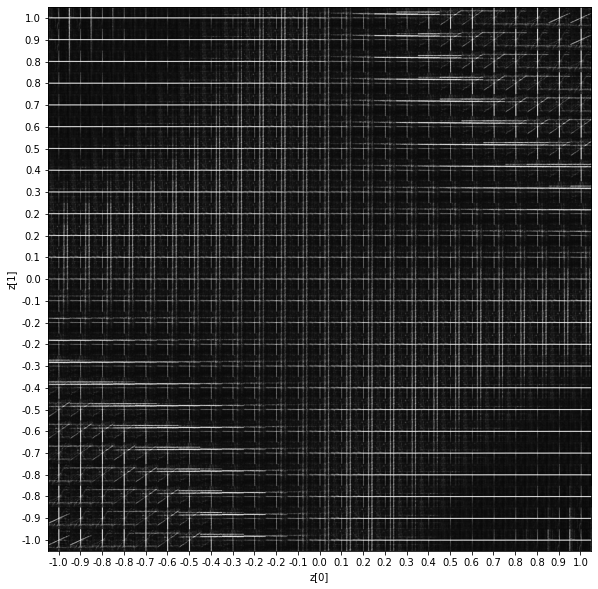

In [127]:

"""
## Display a grid of sampled digits
"""


import matplotlib.pyplot as plt


def plot_latent_space(vae, n=25, figsize=10):
    # display a n*n 2D manifold of digits
    digit_size = 256
    scale = 1
    figure = np.zeros((digit_size * n, digit_size * n, 1))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array( [ [xi*yi]*24+[xi*xi,yi*yi] + [0.5]*24 ] )
            x_decoded = vae.decoder.predict(z_sample)
            x_decoded = interval_mapping(x_decoded,0.0,1,0,255)
#             print(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size,1)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit
#             print(digit)

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)



In [ ]:
images[0].shape

In [ ]:
# val[1:20][0]
for v in val:
    print(v.shape)
    break

In [47]:
np.reshape(v,(1,256,256,3))

array([[[[0.31764706, 0.37254902, 0.23137255],
         [0.31764706, 0.37254902, 0.23137255],
         [0.31764706, 0.37254902, 0.23137255],
         ...,
         [0.30588235, 0.3372549 , 0.24313725],
         [0.30196078, 0.34117647, 0.24313725],
         [0.30588235, 0.3372549 , 0.24313725]],

        [[0.32156863, 0.37647059, 0.23529412],
         [0.31764706, 0.37254902, 0.23137255],
         [0.31764706, 0.37254902, 0.23137255],
         ...,
         [0.30588235, 0.3372549 , 0.24313725],
         [0.30588235, 0.3372549 , 0.24313725],
         [0.30588235, 0.3372549 , 0.24313725]],

        [[0.32156863, 0.37647059, 0.23529412],
         [0.32156863, 0.37647059, 0.23529412],
         [0.31764706, 0.37254902, 0.23137255],
         ...,
         [0.30588235, 0.3372549 , 0.24313725],
         [0.30588235, 0.3372549 , 0.24313725],
         [0.30588235, 0.3372549 , 0.24313725]],

        ...,

        [[0.30196078, 0.3254902 , 0.18431373],
         [0.29803922, 0.32156863, 0.18039216]

In [50]:
vae.encoder.predict(np.reshape(v,(1,256,256,3)))

[array([[ 1.73172521e-05,  1.62462500e-04, -1.73196517e-04,
         -3.33510921e-04, -4.41342927e-05,  1.54229114e-04,
          1.23534483e-05,  2.11447215e-04, -1.36003046e-05,
         -1.38024276e-04, -4.21529548e-05,  1.44213700e-05,
         -2.09064747e-04,  2.48554017e-04, -1.08779073e-04,
         -2.74044403e-04,  1.22669837e-04,  8.87642091e-06,
          9.00263040e-05, -1.46110280e-04,  1.15345276e-04,
          1.77681213e-04,  2.14652624e-04, -5.86012538e-06,
          2.58993823e-05,  6.22833904e-05,  6.00576786e-05,
         -1.72355183e-04, -7.88673642e-05, -2.57875479e-04,
          6.40884391e-05,  4.70193590e-05,  1.85235658e-05,
         -1.17626660e-05,  3.67351167e-05, -6.78934448e-05,
         -2.60088360e-04, -2.67993833e-04,  1.99257061e-04,
         -1.18377859e-04,  2.87029048e-04,  5.95780875e-07,
          3.04235073e-05,  5.93296645e-05,  1.24743165e-04,
          8.42442241e-05,  2.57327774e-05, -9.10307790e-05,
         -6.41700608e-05,  1.89837010e-0

(256, 256, 1)


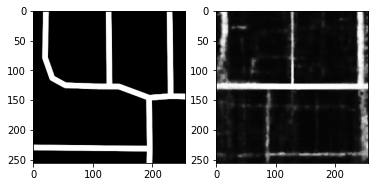

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

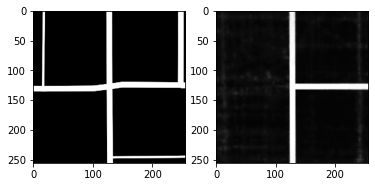

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

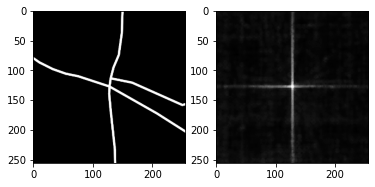

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

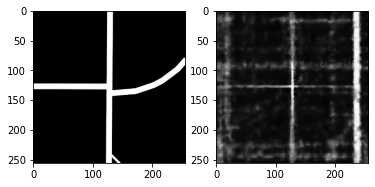

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

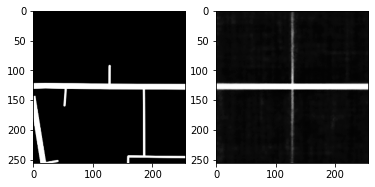

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

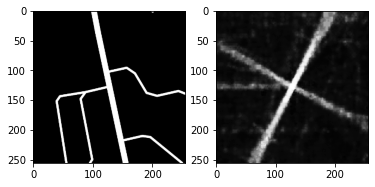

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

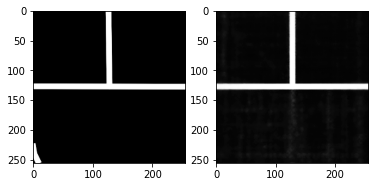

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

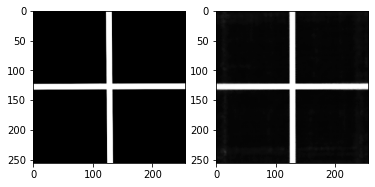

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

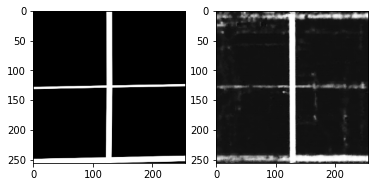

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

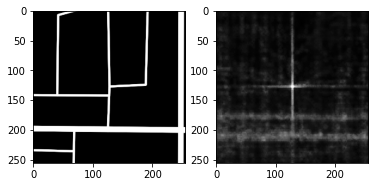

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

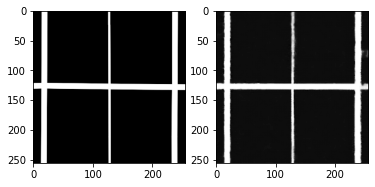

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

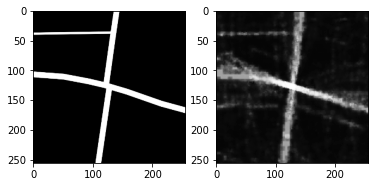

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

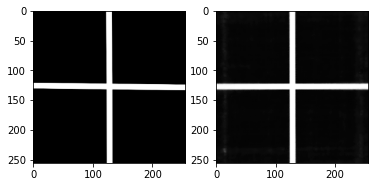

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

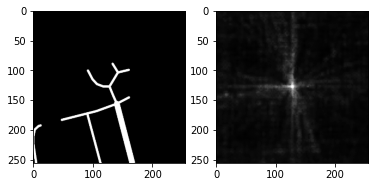

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

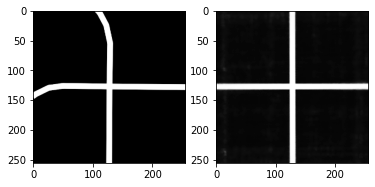

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

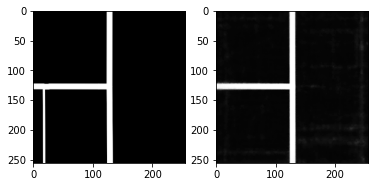

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

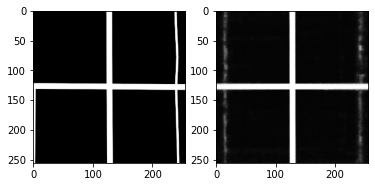

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

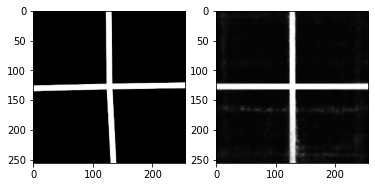

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

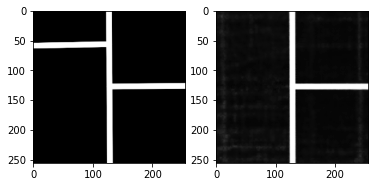

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

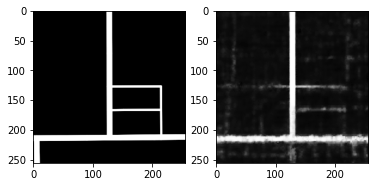

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

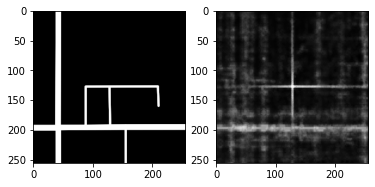

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

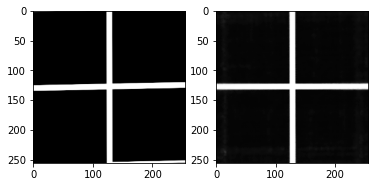

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

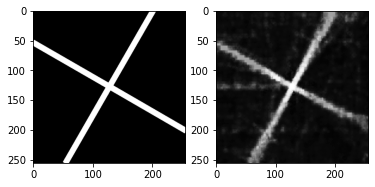

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

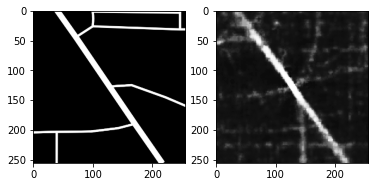

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

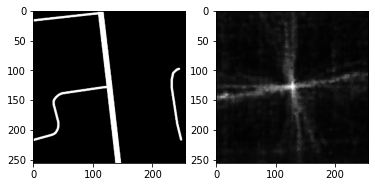

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

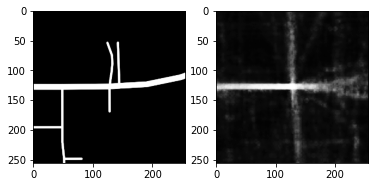

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

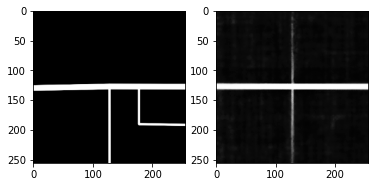

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

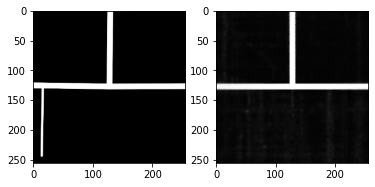

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

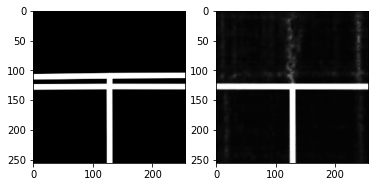

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

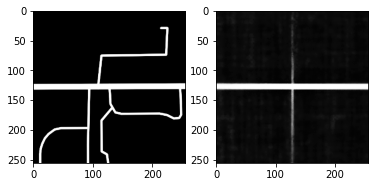

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

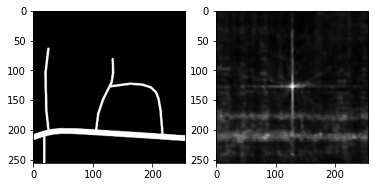

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

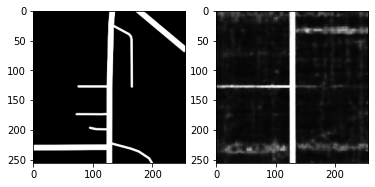

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

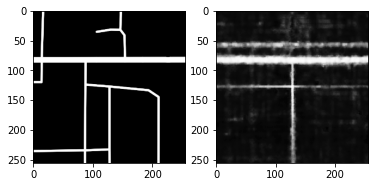

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

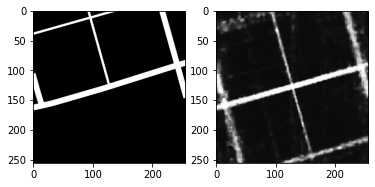

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

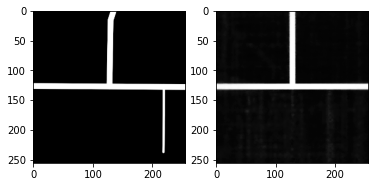

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

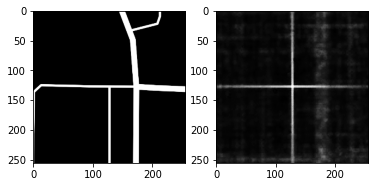

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

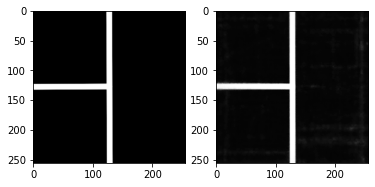

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

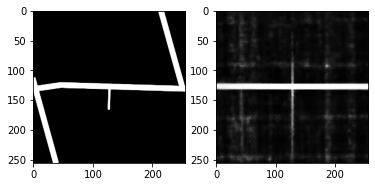

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

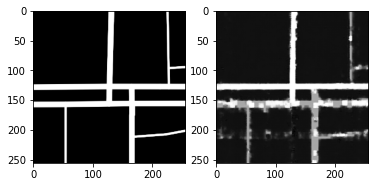

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

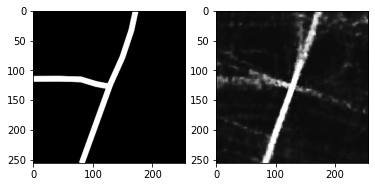

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

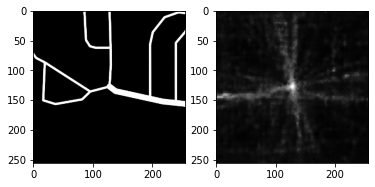

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

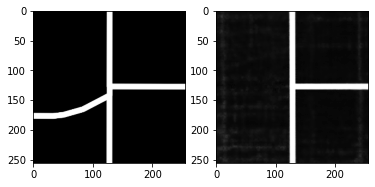

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

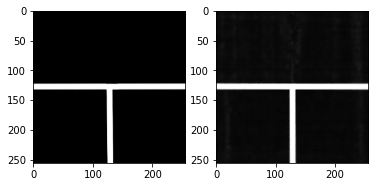

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

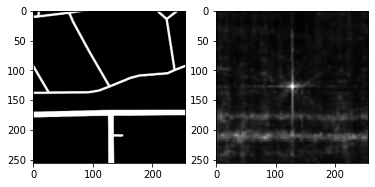

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

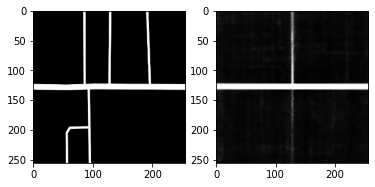

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

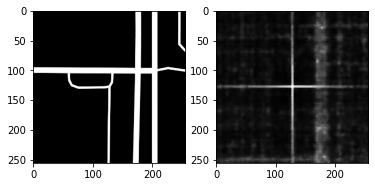

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

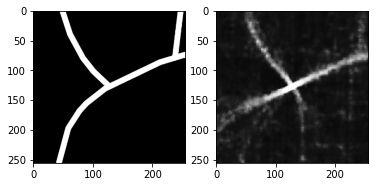

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

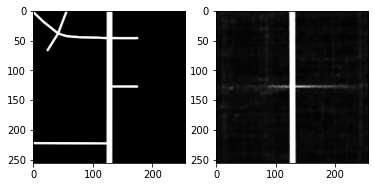

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

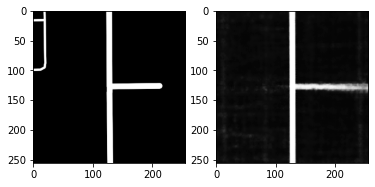

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

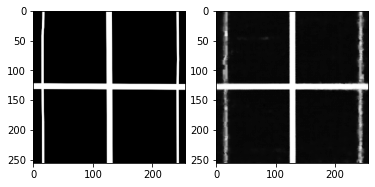

<Figure size 432x288 with 0 Axes>

In [131]:
for i,v in enumerate(val[0:50]):
    print(v.shape)
    f, ax = plt.subplots(1,2)
    ax[0].imshow(v, cmap="Greys_r")
    x_decoded = vae.decoder.predict(vae.encoder.predict( np.reshape(v,(1,256,256,1)))[0])
    x_decoded = interval_mapping(x_decoded,0.0,1,0,255)
    digit = x_decoded[0].reshape(256, 256,1)
    ax[1].imshow(digit, cmap="Greys_r")
    plt.show()
    plt.savefig("comparison_"+str(i)+".png")
    if i > 150:
        break


In [79]:
first_half = vae.encoder.predict(val[:5000])

In [80]:
last_half = vae.encoder.predict(val[5000:])

In [137]:
output = {}
output['nodes'] = [x.split("/")[-1].split("_")[-1].split(".")[0] for x in file_list][4000:]
output['vectors'] = np.concatenate(first_half[0],last_half[0])

TypeError: only integer scalar arrays can be converted to a scalar index

In [141]:
# np.reshape(v,(1,256,256,1)))[0]
first_half[0].shape
len([x.split("/")[-1].split("_")[-1].split(".")[0] for x in file_list][4000:])

6002

In [ ]:
import pandas as pd
pd.DataFrame(output,index=output['nodes']).to_json("encoded_masks.json")

In [147]:
vae.save_weights("vae_weights")

In [ ]:
vae.save_spec()